Un propietario de una casa rural está buscando formas de regar un pequeño huerto familiar. 

Una posibilidad que se está considerando es utilizar el agua de un pequeño arroyo que está a 38 mts de distancia del jardín y 8 mts más abajo que el jardín. 

Determine las especificaciones para un sistema de bombas y tuberías que suministre agua de riego al jardín a un caudal de 20 litros por minuto.

In [1]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
from scipy.constants import g

Datos

In [2]:
z = 8  #mts

L = 38 #mts

V_dot_lm = 20 # lts/min
V_dot = V_dot_lm/(1000 * 60) # lts/min

Para suministrar el agua de riego al jardín, la bomba debe suministrar suficiente presión para superar (1) la diferencia de altitud y (2) los efectos de fricción en la red de tuberías de la red,

$\Delta P_{\text {pump}}=\Delta P_{\text{elevation}}+\Delta P_{\text{friction}}$


El aumento de presión necesario para superar la diferencia de altitud es

$ \Delta P_{\text{elevation}}= \rho g z $



In [3]:
fluid = 'water'
P_o = 101325
T_o = 25 + 273.15
rho = cp.PropsSI("D", "T", T_o, "P", P_o, fluid)
mu = cp.PropsSI("V","T", T_o, "P", P_o, fluid)

In [4]:
DELTA_P_e = rho * g * z

DELTA_P_e

78221.57765628686

La pérdida de carga debido a la fricción puede calcularse realizando un análisis de la fricción de la tubería,

$\Delta P_{\text{friction}} =f \frac{L}{D} \frac{\rho V^{2}}{2}$

La velocidad en la tubería es una función del caudal y del diámetro de la tubería,

$V=\frac{\dot{V}}{A}=\frac{4 \dot{V}}{\pi D^{2}}$

Sustituyendo esta expresión en la ecuación de la caída de presión por fricción se obtiene

$\Delta P_{\text {friction }}=f \frac{8 \rho L \dot{V}^{2}}{\pi^{2} D^{5}}$

In [5]:
D = 0.02
A_D = (np.pi * D**2)/4
V = V_dot / A_D
Re = fld.Reynolds(D, rho, V, mu)


In [6]:
epsilon = fld.roughness_Farshad('Plastic coated', D)
f = fld.friction.friction_factor(Re, eD=epsilon/D)
f

0.025419834653613246

In [7]:
DELTA_P_f = (f * 8 * rho * (L + z) * V_dot**2)/(np.pi**2 * D**5)
DELTA_P_f

32812.86980148238

Pérdida de carga por Singularidades: 2 codos de 90 grados

$\Delta P_{singular} = \sum_{i}{K_i \rho \frac{V_1^2}{2}}$


In [22]:
K = fld.fittings.bend_rounded_Crane(Di=D, bend_diameters=2, angle=90) # bend_diameters = Number of diameters of pipe making up the bend radius

DELTA_P_s = 2 * (K * rho * 8* V_dot**2)/(np.pi**2 * D**4)
DELTA_P_s 

319.82563292924823

In [23]:
Delta_P = DELTA_P_f + DELTA_P_e + DELTA_P_s
Delta_P

111301.23015642285

**Análisis de Sensibilidad**

vectorized module wraps all of the fluids functions with np.vectorize

---> also explore fluids.numba_vectorized 

In [12]:
from fluids.vectorized import * 

In [24]:
D_range = np.array([0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])*25.4/1000

A_range = (np.pi * D_range**2)/4
V_range = V_dot / A_range
Re_range = Reynolds(D_range, rho, V_range, mu)

epsilon_range = roughness_Farshad('Plastic coated', D_range)
eD_range = epsilon_range/D_range

In [27]:
f_range = friction_factor(Re=Re_range, eD=eD_range) 

f_range

array([0.02224135, 0.02348694, 0.02517704, 0.02672777, 0.02811751,
       0.02937306, 0.03052043, 0.0315799 ])

In [28]:
DELTA_P_f_range = (f_range * 8 * rho * (L + z) * V_dot**2)/(np.pi**2 * D_range**5)

DELTA_P_f_range

array([8.89844135e+06, 2.93649510e+05, 4.14525548e+04, 1.04427693e+04,
       3.59981035e+03, 1.51128276e+03, 7.26529571e+02, 3.85579303e+02])

In [34]:
K_range = bend_rounded_Crane(Di=D_range, bend_diameters=2, angle=90) # bend_diameters = Number of diameters of pipe making up the bend radius
K_range

array([0.39618504, 0.32256929, 0.28864008, 0.2677113 , 0.25300592,
       0.2418716 , 0.23302106, 0.22574108])

In [35]:
DELTA_P_s_range = 2 * (K_range * rho * 8* V_dot**2)/(np.pi**2 * D_range**4)
DELTA_P_s_range

array([4.37619649e+04, 2.22690541e+03, 3.93613833e+02, 1.15511566e+02,
       4.47146052e+01, 2.06147756e+01, 1.07201717e+01, 6.08764605e+00])

In [39]:
Delta_P_range = DELTA_P_f_range + DELTA_P_e + DELTA_P_s_range
Delta_P_range


array([9020371.85246683,  374044.95051674,  120014.70331483,
         88726.81558946,   81813.05967226,   79700.4322566 ,
         78905.78446469,   78560.20167144])

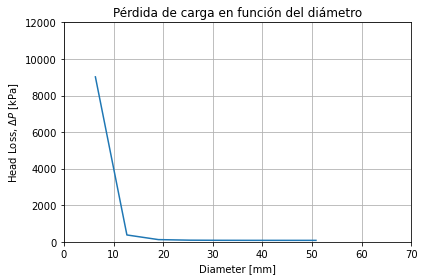

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(D_range * 1000, Delta_P_range/1000)
plt.xlabel("Diameter [mm]")
plt.ylabel(r"Head Loss, $\Delta P$ [kPa]")
plt.title("Pérdida de carga en función del diámetro")
plt.xlim([0, 70])
plt.ylim([0, 12000])
plt.grid(True)
plt.tight_layout()